In [2]:
%pylab inline
import torch
import numpy
import sklearn.datasets
import torchvision.datasets
import os
from pycocotools import coco
from scipy.misc import imresize as imgresize
torch.manual_seed(0)

Populating the interactive namespace from numpy and matplotlib


In [3]:
train_dest = "../../val2017"
target_dest = "../../annotations/instances_val2017_people.json"

In [4]:
# import json 
# spooky scary preprocessing
# with open("../../annotations/instances_val2017.json") as rfile, open("../../annotations/instances_val2017_people.json", 'w') as wfile:
#     data = json.load(rfile)
#     data["annotations"] = list(filter(lambda x: x["category_id"] == 1, data["annotations"]))
#     json.dump(data, wfile)

# with open("../../annotations/instances_train2017.json") as rfile, open("../../annotations/instances_train2017_people.json", 'w') as wfile:
#     data = json.load(rfile)
#     data["annotations"] = list(filter(lambda x: x["category_id"] == 1, data["annotations"]))
#     json.dump(data, wfile)

In [5]:
COCO = coco.COCO(target_dest)

def toMask(x):
    return np.sum(COCO.annToMask(i) > 0 for i in x)

def resizeNP(x):
    if type(x) == int and x == 0:
        return np.zeros((320, 320))
    return (imgresize(x, (320, 320), 'bilinear') > 0).astype(int)
    
def toTensor(x):
    return torch.from_numpy(x).float().unsqueeze(0)

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


In [6]:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((320, 320)), #реобразует картинку к указанному размеру
         torchvision.transforms.ToTensor()                   # Переводит объект "картинка" к torch.Tensor
    ])

train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Lambda(toMask),
        torchvision.transforms.Lambda(resizeNP),
        torchvision.transforms.Lambda(toTensor),        
    ])

In [7]:
dataset = torchvision.datasets.CocoDetection(train_dest, target_dest, 
                                             transform=transforms, target_transform=train_transforms)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [181]:
def showimgs(imgs_tensor):
    for tensor in imgs_tensor:
        plt.imshow(tensor.squeeze(0).numpy())
        plt.show()

/home/teacher/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


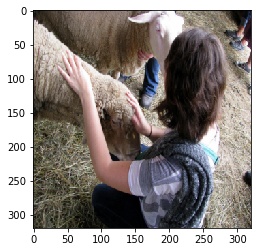

In [182]:
plt.imshow(dataset[2][0].numpy().swapaxes(0,1).swapaxes(1,2))
plt.show()

In [183]:
dataset[2][1]

/home/teacher/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


tensor([[[ 0.,  0.,  0.,  ...,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  ...,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  ...,  1.,  1.,  1.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]])

In [111]:
# class UNetConvBlock(nn.Module):
#     def __init__(self, in_size, out_size, kernel_size=3, activation=F.relu):
#         super(UNetConvBlock, self).__init__()
#         self.conv = nn.Conv2d(in_size, out_size, kernel_size)
#         self.conv2 = nn.Conv2d(out_size, out_size, kernel_size)
#         self.activation = activation

#     def forward(self, x):
#         out = self.activation(self.conv(x))
#         out = self.activation(self.conv2(out))

#         return out

# class UNetUpBlock(nn.Module):
#     def __init__(self, in_size, out_size, kernel_size=3, activation=F.relu, space_dropout=False):
#         super(UNetUpBlock, self).__init__()
#         self.up = nn.ConvTranspose2d(in_size, out_size, 2, stride=2)
#         self.conv = nn.Conv2d(in_size, out_size, kernel_size)
#         self.conv2 = nn.Conv2d(out_size, out_size, kernel_size)
#         self.activation = activation

#     def center_crop(self, layer, target_size):
#         batch_size, n_channels, layer_width, layer_height = layer.size()
#         xy1 = (layer_width - target_size) // 2
#         return layer[:, :, xy1:(xy1 + target_size), xy1:(xy1 + target_size)]

#     def forward(self, x, bridge):
#         up = self.up(x)
#         crop1 = self.center_crop(bridge, up.size()[2])
#         out = torch.cat([up, crop1], 1)
#         out = self.activation(self.conv(out))
#         out = self.activation(self.conv2(out))

#         return out

In [48]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [49]:
class UNetConvBlock(torch.nn.Module):
    def __init__(self, in_layers, out_layers, kernel_size=3, padding=1, activation=torch.nn.ReLU, pooling=True):
        super(UNetConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(in_layers, out_layers, kernel_size, padding=padding)
        self.conv2 = torch.nn.Conv2d(out_layers, out_layers, kernel_size, padding=padding)
        self.pool = torch.nn.MaxPool2d(2)
        self.activation = activation()
        
        self.pooling = pooling
        
    def forward(self, x):
        out = self.activation(self.conv(x))
        out = self.activation(self.conv2(out))
        if (self.pooling):
            out = self.pool(out)
        return out     
    
class UNetUpConvBlock(torch.nn.Module):
    def __init__(self, in_layers, kernel_size=3, padding=1, activation=torch.nn.ReLU):
        super(UNetUpConvBlock, self).__init__()
        self.upconv = torch.nn.Conv2d(in_layers, 4*in_layers, 1)
        self.transpose = torch.nn.ConvTranspose2d(4*in_layers, in_layers, 2, stride=2)
        self.conv = UNetConvBlock(in_layers, in_layers, pooling=False)  
        
    def forward(self, x):
        out = self.upconv(x)
        out = self.transpose(out)
        print("After ups and transpose", out.size())
        out = self.conv(out)
        return out    

In [50]:
class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.conv1 = UNetConvBlock(3, 16)
        self.conv2 = UNetConvBlock(16, 32)
        self.conv3 = UNetConvBlock(32, 64)

        self.upconv3 = UNetUpConvBlock(64)
        self.upconv2 = UNetUpConvBlock(64)
        self.upconv1 = UNetUpConvBlock(64)
        
        self.fullconv = torch.nn.Conv2d(64, 1, 1)  
        self.pred = torch.nn.Sigmoid()
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)          
        x = self.conv3(x)
        
        print("After convs ")
        print(x.size())
        
        x = self.upconv3(x)
        x = self.upconv2(x)
        x = self.upconv1(x)
        
        x = self.fullconv(x)    
        x = self.pred(x)
        return x

In [32]:
net = UNet().to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters())

In [33]:
from operator import itemgetter

def make_batch(dataset, order):
    items = itemgetter(*order)(dataset)
    data, targets = zip(*items)
    data = list(map(lambda x: x.unsqueeze(0), data))
    targets = list(map(lambda x: x.unsqueeze(0), targets))
    return torch.cat(data, dim=0), torch.cat(targets, dim=0)

In [34]:
batch_size = 4
for epoch in range(10):
    order = random.permutation(len(dataset.ids))
    net.train()
    for start_index in range(0, len(dataset.ids), batch_size):
        optimizer.zero_grad()
        
        batch_indice = list(order[start_index:start_index+batch_size])

        batch_features, batch_labels = make_batch(dataset, batch_indice)
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        batch_preds = net.forward(batch_features)

        loss = criterion(batch_preds, batch_labels)
        
        loss.backward()
        
        optimizer.step()
        
        print(loss)

/home/teacher/.local/lib/python3.5/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


After convs 
torch.Size([4, 64, 40, 40])
After ups and transpose torch.Size([4, 64, 80, 80])
After ups and transpose torch.Size([4, 64, 160, 160])
After ups and transpose torch.Size([4, 64, 320, 320])
tensor(0.7496, device='cuda:0')
After convs 
torch.Size([4, 64, 40, 40])
After ups and transpose torch.Size([4, 64, 80, 80])
After ups and transpose torch.Size([4, 64, 160, 160])
After ups and transpose torch.Size([4, 64, 320, 320])
tensor(0.7350, device='cuda:0')
After convs 
torch.Size([4, 64, 40, 40])
After ups and transpose torch.Size([4, 64, 80, 80])
After ups and transpose torch.Size([4, 64, 160, 160])
After ups and transpose torch.Size([4, 64, 320, 320])
tensor(0.7187, device='cuda:0')
After convs 
torch.Size([4, 64, 40, 40])
After ups and transpose torch.Size([4, 64, 80, 80])
After ups and transpose torch.Size([4, 64, 160, 160])
After ups and transpose torch.Size([4, 64, 320, 320])
tensor(0.6927, device='cuda:0')
After convs 
torch.Size([4, 64, 40, 40])
After ups and transpose tor

tensor(1.00000e-19 *
       8.9761, device='cuda:0')
After convs 
torch.Size([4, 64, 40, 40])
After ups and transpose torch.Size([4, 64, 80, 80])
After ups and transpose torch.Size([4, 64, 160, 160])
After ups and transpose torch.Size([4, 64, 320, 320])
tensor(1.00000e-19 *
       5.6129, device='cuda:0')
After convs 
torch.Size([4, 64, 40, 40])
After ups and transpose torch.Size([4, 64, 80, 80])
After ups and transpose torch.Size([4, 64, 160, 160])
After ups and transpose torch.Size([4, 64, 320, 320])
tensor(1.00000e-19 *
       6.2274, device='cuda:0')
After convs 
torch.Size([4, 64, 40, 40])
After ups and transpose torch.Size([4, 64, 80, 80])
After ups and transpose torch.Size([4, 64, 160, 160])
After ups and transpose torch.Size([4, 64, 320, 320])
tensor(1.00000e-18 *
       1.3839, device='cuda:0')
After convs 
torch.Size([4, 64, 40, 40])
After ups and transpose torch.Size([4, 64, 80, 80])
After ups and transpose torch.Size([4, 64, 160, 160])
After ups and transpose torch.Size([4,

KeyboardInterrupt: 

In [ ]:
# class UNet(torch.nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()
#         self.conv1 = torch.nn.Conv2d(3, 32, 3, padding=1) #32 layers
#         self.pool1 = torch.nn.MaxPool2d(2, 2)
        
#         self.conv2 = torch.nn.Conv2d(32, 256, 3, padding=1) #256 layers
#         self.pool2 = torch.nn.MaxPool2d(2, 2)
        
#         self.conv3 = torch.nn.Conv2d(256, 1024, 3, padding=1) #1024 layers
#         self.pool3 = torch.nn.MaxPool2d(2, 2)
        
#         self.upconv3 = torch.nn.ConvTranspose2d(1024, 256, 2, 2) # 256 layers + 256 after concat
        
#         self.upconv2 = torch.nn.ConvTranspose2d(256, 64, 2, 2) # 128 layers + 32 layers after concat
        
#         self.upconv1 = torch.nn.ConvTranspose2d(64, 16, 2, 2) # 40 layers + 

#         self.fullconv = torch.nn.Conv2d(16, 1, 1)  
        
#         self.pred = torch.nn.Sigmoid()
#     def forward(self, x):

#         x = self.conv1(x)
#         x = self.pool1(x)
        
#         x = self.conv2(x)     
#         x = self.pool2(x)
        
#         x = self.conv3(x)
#         x = self.pool3(x)
        
# #         print(x.size())
        
#         x = self.upconv3(x)

#         x = self.upconv2(x)

#         x = self.upconv1(x)

#         x = self.fullconv(x)      
        
# #         print(x.size())
        
#         x = self.pred(x)
#         return x

In [35]:
net = net.cpu()

/home/teacher/.local/lib/python3.5/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


After convs 
torch.Size([4, 64, 40, 40])
After ups and transpose torch.Size([4, 64, 80, 80])
After ups and transpose torch.Size([4, 64, 160, 160])
After ups and transpose torch.Size([4, 64, 320, 320])
torch.Size([4, 1, 320, 320])


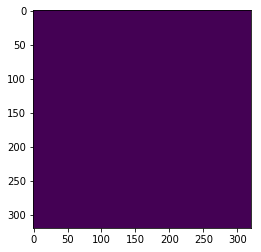

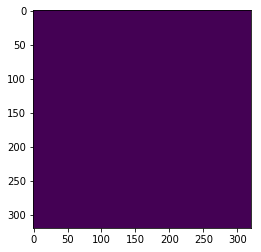

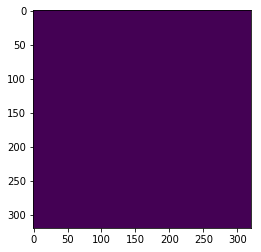

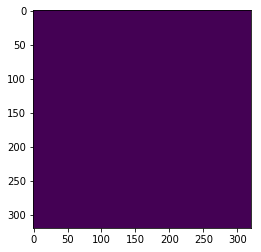

In [51]:
test = make_batch(dataset, [i for i in range(4)])[0]

preds = net.forward(test).cpu().data
print(preds.shape)
showimgs(preds)

/home/teacher/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


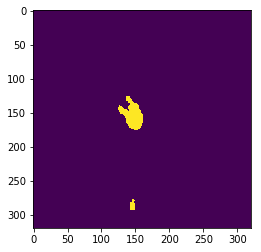

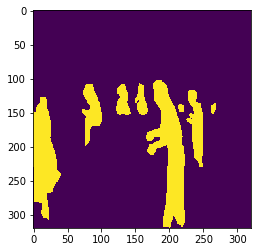

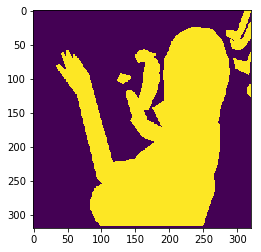

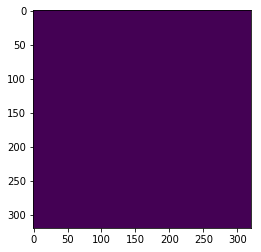

In [184]:
showimgs(make_batch(dataset, [i for i in range(4)])[1])